# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from pprint import pprint

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score
# from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder
# from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
# from sklearn.externals import joblib
# from imblearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import xgboost as xgb
import lightgbm as lgb

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.callbacks import DeadlineStopper # Stop the optimization before running out of a fixed budget of time.
from skopt.callbacks import VerboseCallback # Callback to control the verbosity
from skopt.callbacks import DeltaXStopper # Stop the optimization If the last two positions at which the objective has been evaluated are less than delta

# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
# display more rows and columns
def show_all(df, rows=100, columns=1000):
    """
    Displays 100 rows and 1000 columns
    
    Args:
        df (DataFrame): DataFrame to display
    """
    with pd.option_context("display.max_rows", rows, "display.max_columns", 1000):
        display(df)

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [3]:
# load in the population data
azdias = pd.read_csv('./data/Udacity_AZDIAS_052018.csv', sep=';')

c:\users\kenne\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# load in the customer data
customers = pd.read_csv('./data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [5]:
# shape inspection
print(azdias.shape)
print(customers.shape)

(891221, 366)
(191652, 369)


In [6]:
# features only present in customer dataset
unique_customer_features = set(customers.columns.values) - set(azdias.columns.values)

In [7]:
# examine unique_customer_features
customers[unique_customer_features].head()

,PRODUCT_GROUP,ONLINE_PURCHASE,CUSTOMER_GROUP
0,COSMETIC_AND_FOOD,0,MULTI_BUYER
1,FOOD,0,SINGLE_BUYER
2,COSMETIC_AND_FOOD,0,MULTI_BUYER
3,COSMETIC,0,MULTI_BUYER
4,FOOD,0,MULTI_BUYER


In [8]:
# as I got no use for these customer specific features in this analysis they are dropped to keep harmony between the two dataframes
customers.drop(columns=unique_customer_features, inplace=True)

In [9]:
# shape inspection after column harmonisation
print(azdias.shape)
print(customers.shape)

(891221, 366)
(191652, 366)


In [10]:
# general stats
# azdias.describe()

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Load and utilize attributes info file
This file describes how many of the "-1" and "0" values actually refers to "unknown" meanings. These unknown values are traced down and replaced with NaNs.

In [11]:
# read attributes info
feat = pd.read_excel('DIAS Attributes - Values 2017.xlsx', engine='openpyxl')

In [12]:
# forward fill
feat.fillna(method='ffill', inplace=True)
feat.head(8)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,age classification through prename analysis,1,< 30 years
7,ALTERSKATEGORIE_GROB,age classification through prename analysis,2,30 - 45 years


In [13]:
# 'Attribute' and 'Value' for where Meaning contains 'unknown'
feat[feat['Meaning'].str.contains('unknown')][['Attribute', 'Meaning', 'Value']].head()

,Attribute,Meaning,Value
0,AGER_TYP,unknown,-1
5,ALTERSKATEGORIE_GROB,unknown,"-1, 0"
11,ALTER_HH,unknown / no main age detectable,0
33,ANREDE_KZ,unknown,"-1, 0"
40,BALLRAUM,unknown,-1


In [14]:
# possible
feat[feat['Meaning'].str.contains('possible')][['Attribute', 'Meaning', 'Value']].head()

,Attribute,Meaning,Value
1,AGER_TYP,no classification possible,0
745,HEALTH_TYP,classification not possible,0


In [15]:
# not known
feat[feat['Meaning'].str.contains("no transactions? known")][['Attribute', 'Meaning', 'Value']].head()

,Attribute,Meaning,Value
138,D19_BANKEN_ANZ_12,no transactions known,0
145,D19_BANKEN_ANZ_24,no transactions known,0
161,D19_BANKEN_DATUM,no transactions known,10
162,D19_BANKEN_DIREKT_RZ,no transaction known,0
170,D19_BANKEN_GROSS_RZ,no transaction known,0


In [16]:
# # known
# not_known = feat[feat['Meaning'].str.contains('know')][['Attribute', 'Meaning', 'Value']]
# not_known = not_known[~not_known.Meaning.str.contains("unknown")]
# not_known[~not_known.Meaning.str.contains("no transactions? known")].head(50)

In [17]:
# all of the "unknown"-like values
unknown_values = feat[feat['Meaning'].str.contains(
    '|'.join(['unknown', 'possible', 'no transactions? known']))][['Attribute', 'Value']]

with the values of interest mapped they can then be replaced:

In [18]:
def replace_unknowns_with_nans(df):
    for att, vals in unknown_values.values:
        if isinstance(vals, str):
            vals = [int(x) for x in vals.split(', ')]
        if isinstance(vals, int):
            vals = [vals]
        for val in vals:
            # print(f"Att. '{att}': replaced value {val} with NaN")
            try:
                df[att].replace({val: np.nan}, inplace=True)
            except KeyError as e:
                print('KeyErrors:', e)

In [19]:
# Replace unknown_values with NaNs
replace_unknowns_with_nans(azdias)
replace_unknowns_with_nans(customers)

KeyErrors: 'BIP_FLAG'
KeyErrors: 'CAMEO_DEUINTL_2015'
KeyErrors: 'D19_BANKEN_DIREKT_RZ'
KeyErrors: 'D19_BANKEN_GROSS_RZ'
KeyErrors: 'D19_BANKEN_LOKAL_RZ'
KeyErrors: 'D19_BANKEN_REST_RZ'
KeyErrors: 'D19_BEKLEIDUNG_GEH_RZ'
KeyErrors: 'D19_BEKLEIDUNG_REST_RZ'
KeyErrors: 'D19_BILDUNG_RZ'
KeyErrors: 'D19_BIO_OEKO_RZ'
KeyErrors: 'D19_BUCH_RZ'
KeyErrors: 'D19_DIGIT_SERV_RZ'
KeyErrors: 'D19_DROGERIEARTIKEL_RZ'
KeyErrors: 'D19_ENERGIE_RZ'
KeyErrors: 'D19_FREIZEIT_RZ'
KeyErrors: 'D19_GARTEN_RZ'
KeyErrors: 'D19_HANDWERK_RZ'
KeyErrors: 'D19_HAUS_DEKO_RZ'
KeyErrors: 'D19_KINDERARTIKEL_RZ'
KeyErrors: 'D19_KK_KUNDENTYP'
KeyErrors: 'D19_KOSMETIK_RZ'
KeyErrors: 'D19_LEBENSMITTEL_RZ'
KeyErrors: 'D19_LOTTO_RZ'
KeyErrors: 'D19_NAHRUNGSERGAENZUNG_RZ'
KeyErrors: 'D19_RATGEBER_RZ'
KeyErrors: 'D19_REISEN_RZ'
KeyErrors: 'D19_SAMMELARTIKEL_RZ'
KeyErrors: 'D19_SCHUHE_RZ'
KeyErrors: 'D19_SONSTIGE_RZ'
KeyErrors: 'D19_TECHNIK_RZ'
KeyErrors: 'D19_TELKO_MOBILE_RZ'
KeyErrors: 'D19_TELKO_REST_RZ'
KeyErrors: 'D19_TIERAR

the KeyErrors represent attributes listed in feature info file but did nor exist in either of the dataframes

### DtypeWarning: Columns (19,20) have mixed types
Some of the columns results in a DtypeWarning as they apparently contains a combination of int, str, nan and some of the strings are even 'X' and 'XX'.

In [20]:
# list of problematic columns
dtype_columns = customers.iloc[:,18:21].columns.tolist()
dtype_columns

['CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'CJT_GESAMTTYP']

In [21]:
# inspect current most likely incorrect dtypes
customers[dtype_columns].dtypes

CAMEO_DEUG_2015     object
CAMEO_INTL_2015     object
CJT_GESAMTTYP      float64
dtype: object

In [22]:
# values before correction including a combination of floats, nans and strings but should be ints
customers[dtype_columns].values

array([[1.0, 13.0, 5.0],
       [nan, nan, nan],
       [5.0, 34.0, 2.0],
       ...,
       ['4', '24', 2.0],
       ['4', '24', 4.0],
       ['5', '33', 2.0]], dtype=object)

In [23]:
def correct_dtypes(df, column_names):
    df[dtype_columns] = df[dtype_columns].replace('X',np.nan).replace('XX',np.nan).astype('float').astype('Int32')

In [24]:
# correct dtype_columns
correct_dtypes(customers, dtype_columns)
correct_dtypes(azdias, dtype_columns)

In [25]:
customers[dtype_columns].values

array([[1, 13, 5],
       [<NA>, <NA>, <NA>],
       [5, 34, 2],
       ...,
       [4, 24, 2],
       [4, 24, 4],
       [5, 33, 2]], dtype=object)

### Replace all 'X' values
The following are slow scans but for both datasets only 'CAMEO_DEU_2015' is detected.

In [26]:
# scan all columns for any further "X" values
# for col in customers.columns:
#     count = customers[col].astype(str).str.contains('X').sum()
#     if count:
#         print(count, col)

In [27]:
# scan all columns for any further "X" values
# for col in azdias.columns:
#     count = azdias[col].astype(str).str.contains('X').sum()
#     if count:
#         print(count, col)

In [28]:
# fix the last incorrect 'X' values
customers['CAMEO_DEU_2015'].replace('XX', np.nan, inplace=True)
azdias['CAMEO_DEU_2015'].replace('XX', np.nan, inplace=True)

can stay as object

### Dropping columns with high degree of nans

In [29]:
# columns where more than 33% of the rows contain nans are discarded to avoid introducing too much noise in the imputer phase.
def poor_columns(df, threshold=33):
    missing_procentage = df.isnull().sum(axis=0)/len(df)*100
    features_to_drop = missing_procentage[missing_procentage>threshold]
    return features_to_drop.sort_values(ascending=False)

In [ ]:
# find columns with many missing values
features_to_drop1 = poor_columns(customers)

In [ ]:
features_to_drop2 = poor_columns(azdias)

In [32]:
# union the two sets to ensure the same columns are discarded
features_to_drop = set(features_to_drop1.keys().values.tolist()).union(set(features_to_drop2.keys().values.tolist()))
features_to_drop

{'AGER_TYP',
 'ALTER_HH',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'D19_BANKEN_ANZ_12',
 'D19_BANKEN_ANZ_24',
 'D19_BANKEN_DATUM',
 'D19_BANKEN_OFFLINE_DATUM',
 'D19_BANKEN_ONLINE_DATUM',
 'D19_GESAMT_ANZ_12',
 'D19_GESAMT_ANZ_24',
 'D19_GESAMT_DATUM',
 'D19_GESAMT_OFFLINE_DATUM',
 'D19_GESAMT_ONLINE_DATUM',
 'D19_TELKO_ANZ_12',
 'D19_TELKO_ANZ_24',
 'D19_TELKO_DATUM',
 'D19_TELKO_OFFLINE_DATUM',
 'D19_TELKO_ONLINE_DATUM',
 'D19_VERSAND_ANZ_12',
 'D19_VERSAND_ANZ_24',
 'D19_VERSAND_DATUM',
 'D19_VERSAND_OFFLINE_DATUM',
 'D19_VERSAND_ONLINE_DATUM',
 'D19_VERSI_ANZ_12',
 'D19_VERSI_ANZ_24',
 'EXTSEL992',
 'KBA05_BAUMAX',
 'KK_KUNDENTYP',
 'TITEL_KZ'}

In [33]:
# dropping columns with too many missing values
customers.drop(columns=features_to_drop, inplace=True)
azdias.drop(columns=features_to_drop, inplace=True)

In [34]:
# shape inspection after dropping ppor columns
print(azdias.shape)
print(customers.shape)

(891221, 334)
(191652, 334)


### Dropping rows with high degree of nans

In [35]:
# find rows with many missing values
missing_values = customers.isnull().sum(axis=1)
missing_values.sort_values(ascending=False).head(10)

74012    254
89983    254
84107    254
35291    249
40583    249
79091    249
79090    249
79089    249
40564    249
79084    249
dtype: int64

many rows is observed to be missing exactly 250 enties.

In [36]:
# number of rows to drop
missing_values[missing_values>=250].count()

3

dropping those with 250 or more missing enties will result in dropping 41k samples out of 191k samples.
This is so large a chunk of the data that I decided to make the cut right above 250 missing entries which resulted in dropping a very limited number of samples.

In [37]:
# dropping rows with too many missing values
customers = customers[missing_values<=250]

In [38]:
print(customers.shape)

(191649, 334)


Now same logic for azdias

In [39]:
# find rows with many missing values
missing_values = azdias.isnull().sum(axis=1)
missing_values.sort_values(ascending=False).head(10)

826869    254
537799    254
55664     253
373501    253
350182    253
255742    252
5099      252
716386    252
739769    252
23667     252
dtype: int64

In [40]:
# number of rows to drop
missing_values[missing_values>250].count()

18

In [41]:
# dropping rows with too many missing values
azdias = azdias[missing_values<=250]

In [42]:
print(azdias.shape)

(891203, 334)


### Manually inspect the the object dtypes columns

In [43]:
for col in customers.columns:
    if customers[col].dtypes=='object':
        print(customers[col].dtypes, col)

object CAMEO_DEU_2015
object D19_LETZTER_KAUF_BRANCHE
object EINGEFUEGT_AM
object OST_WEST_KZ


In [44]:
# plain string classes that can stay as object for that matter
# customers['CAMEO_DEU_2015'].value_counts()

In [45]:
# plain string classes that can stay as object for that matter
# customers['D19_LETZTER_KAUF_BRANCHE'].value_counts()

In [46]:
customers['EINGEFUEGT_AM'].value_counts()

1992-02-10 00:00:00    64744
1992-02-12 00:00:00    43686
2003-11-18 00:00:00     1066
2005-12-16 00:00:00      808
1995-02-07 00:00:00      569
                       ...  
2001-03-07 00:00:00        1
2000-04-25 00:00:00        1
2000-11-14 00:00:00        1
2015-01-16 00:00:00        1
2001-05-03 00:00:00        1
Name: EINGEFUEGT_AM, Length: 3034, dtype: int64

In [47]:
# 'EINGEFUEGT_AM' with its datetime-like values are also dropped
customers.drop(columns=['EINGEFUEGT_AM'], inplace=True)
azdias.drop(columns=['EINGEFUEGT_AM'], inplace=True)
# could also be reencoded to e.g. year 

In [48]:
# plain string classes that can stay as object for that matter
# customers[['OST_WEST_KZ']].value_counts()

### Class aggregation
For categorical features like 'CAMEO_DEU_2015' that have more than 10 categories should be aggregated into fewer categories when possible

In [49]:
feat.groupby('Attribute').count().reset_index().sort_values(['Value'], ascending=False).head(6)

,Attribute,Description,Value,Meaning
12,CAMEO_DEU_2015,44,44,44
270,LP_LEBENSPHASE_FEIN,40,40,40
11,CAMEO_DEUINTL_2015,26,26,26
2,ALTER_HH,22,22,22
287,PRAEGENDE_JUGENDJAHRE,16,16,16
271,LP_LEBENSPHASE_GROB,12,12,12


In [50]:
# These columns are dropped because they got too many categories and cannot be aggregated nicely
columns_to_drop = ['CAMEO_DEU_2015', 
                   'LP_LEBENSPHASE_FEIN',
#                    'ALTER_HH',  # already dropped due to too many missing values
                   'LP_LEBENSPHASE_GROB']
customers.drop(columns=columns_to_drop, inplace=True)
azdias.drop(columns=columns_to_drop, inplace=True)

CAMEO_DEUINTL_2015 can be aggregated by splitting based on ones and tens

In [51]:
# 'CAMEO_INTL_2015' in dataset is named 'CAMEO_DEUINTL_2015' in feat df. This is first aligned
feat.replace('CAMEO_DEUINTL_2015', 'CAMEO_INTL_2015', inplace=True)
# feat[feat['Attribute']=='CAMEO_INTL_2015']

In [52]:
# extract ones / life_status
customers['life_status'] = customers['CAMEO_INTL_2015'].mod(10)  
azdias['life_status'] = azdias['CAMEO_INTL_2015'].mod(10)

In [53]:
# extract tens / wealth
customers['wealth'] = (customers['CAMEO_INTL_2015'] - customers['life_status'])/10  
azdias['wealth'] = (azdias['CAMEO_INTL_2015'] - azdias['life_status'])/10 

In [54]:
customers.drop(columns=['CAMEO_INTL_2015'], inplace=True)
azdias.drop(columns=['CAMEO_INTL_2015'], inplace=True)

PRAEGENDE_JUGENDJAHRE
covers 3 different features but can be split into 'decade' and 'style' (mainstream/avantgarde)

In [55]:
# prep dict mapper from value to 'style'
style_map = feat[(feat['Attribute']=='PRAEGENDE_JUGENDJAHRE')][['Value', 'Meaning']]
style_map.Meaning = style_map.Meaning.str.split('(').str[1].str.split(',').str[0]
style_map = dict(zip(style_map.Value, style_map.Meaning))

In [56]:
def myTransformer(value, mapper):
    try:
        return mapper[value]
    except KeyError:
        return np.nan

In [57]:
# construct 'style' feature
customers['style'] = customers['PRAEGENDE_JUGENDJAHRE'].apply(myTransformer, mapper=style_map)
azdias['style'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(myTransformer, mapper=style_map)

In [58]:
# prep dict mapper from value to 'decade'
decade_map = feat[(feat['Attribute']=='PRAEGENDE_JUGENDJAHRE')][['Value', 'Meaning']]
decade_map.Meaning = decade_map.Meaning.str.split('ies').str[0]
decade_map.replace('unknown', np.nan, inplace=True)
decade_map = dict(zip(decade_map.Value, decade_map.Meaning))

In [59]:
# construct 'decade' feature
customers['decade'] = customers['PRAEGENDE_JUGENDJAHRE'].apply(myTransformer, mapper=decade_map)
azdias['decade'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(myTransformer, mapper=decade_map)

In [60]:
customers.drop(columns=['PRAEGENDE_JUGENDJAHRE'], inplace=True)
azdias.drop(columns=['PRAEGENDE_JUGENDJAHRE'], inplace=True)

In [61]:
# LNR looks wierd and is dropped
customers.drop(columns=['LNR'], inplace=True)
azdias.drop(columns=['LNR'], inplace=True)

### replace any experimental pd.NA as the imputer wont like them

This appear to change the type back to float64 as np.nan is a float but it's not an issue here as the encoding deals nicely with those as well.

In [62]:
customers = customers.replace({pd.NA: np.nan})

In [63]:
azdias = azdias.replace({pd.NA: np.nan})

### Impute the nans with the most frequent values

In [64]:
# only the most frequent strategy can deal with categorical classes.
# note: mean for numeric, median for int and most_frequent for categoricals would have been better
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

In [65]:
imputer.fit(customers)

SimpleImputer(strategy='most_frequent')

In [66]:
customers = pd.DataFrame(imputer.transform(customers),
                         columns=customers.columns,
                         index=customers.index).astype(customers.dtypes.to_dict())

In [67]:
azdias = pd.DataFrame(imputer.transform(azdias),
                      columns=azdias.columns,
                      index=azdias.index).astype(azdias.dtypes.to_dict())

In [68]:
# customers.fillna(customers.mode().iloc[0])  # equivalent less intuitive pandas method

### convert all floats to int to reduce size
with the NaNs gone the floats can now be converted to int.
Note: Int32 does support nan but could not be applied earlier as it uses pandas experimental pd.nan that the Imputer cannot handle.

In [69]:
def replace_float64_with_int32(df):
    for col in df.columns:
        if df[col].dtypes == 'float64':
            print(df[col].dtypes, col)
            df[col] = df[col].astype('int32')

In [70]:
replace_float64_with_int32(customers)

float64 AKT_DAT_KL
float64 ALTERSKATEGORIE_FEIN
float64 ANZ_HAUSHALTE_AKTIV
float64 ANZ_HH_TITEL
float64 ANZ_KINDER
float64 ANZ_PERSONEN
float64 ANZ_STATISTISCHE_HAUSHALTE
float64 ANZ_TITEL
float64 ARBEIT
float64 BALLRAUM
float64 CAMEO_DEUG_2015
float64 CJT_GESAMTTYP
float64 CJT_KATALOGNUTZER
float64 CJT_TYP_1
float64 CJT_TYP_2
float64 CJT_TYP_3
float64 CJT_TYP_4
float64 CJT_TYP_5
float64 CJT_TYP_6
float64 D19_BANKEN_ONLINE_QUOTE_12
float64 D19_GESAMT_ONLINE_QUOTE_12
float64 D19_KONSUMTYP
float64 D19_LOTTO
float64 D19_SOZIALES
float64 D19_TELKO_ONLINE_QUOTE_12
float64 D19_VERSAND_ONLINE_QUOTE_12
float64 D19_VERSI_ONLINE_QUOTE_12
float64 DSL_FLAG
float64 EINGEZOGENAM_HH_JAHR
float64 EWDICHTE
float64 FIRMENDICHTE
float64 GEBAEUDETYP
float64 GEBAEUDETYP_RASTER
float64 GEMEINDETYP
float64 GFK_URLAUBERTYP
float64 HEALTH_TYP
float64 HH_DELTA_FLAG
float64 HH_EINKOMMEN_SCORE
float64 INNENSTADT
float64 KBA05_ALTER1
float64 KBA05_ALTER2
float64 KBA05_ALTER3
float64 KBA05_ALTER4
float64 KBA05_ANH

In [71]:
replace_float64_with_int32(azdias)

float64 AKT_DAT_KL
float64 ALTERSKATEGORIE_FEIN
float64 ANZ_HAUSHALTE_AKTIV
float64 ANZ_HH_TITEL
float64 ANZ_KINDER
float64 ANZ_PERSONEN
float64 ANZ_STATISTISCHE_HAUSHALTE
float64 ANZ_TITEL
float64 ARBEIT
float64 BALLRAUM
float64 CAMEO_DEUG_2015
float64 CJT_GESAMTTYP
float64 CJT_KATALOGNUTZER
float64 CJT_TYP_1
float64 CJT_TYP_2
float64 CJT_TYP_3
float64 CJT_TYP_4
float64 CJT_TYP_5
float64 CJT_TYP_6
float64 D19_BANKEN_ONLINE_QUOTE_12
float64 D19_GESAMT_ONLINE_QUOTE_12
float64 D19_KONSUMTYP
float64 D19_LOTTO
float64 D19_SOZIALES
float64 D19_TELKO_ONLINE_QUOTE_12
float64 D19_VERSAND_ONLINE_QUOTE_12
float64 D19_VERSI_ONLINE_QUOTE_12
float64 DSL_FLAG
float64 EINGEZOGENAM_HH_JAHR
float64 EWDICHTE
float64 FIRMENDICHTE
float64 GEBAEUDETYP
float64 GEBAEUDETYP_RASTER
float64 GEMEINDETYP
float64 GFK_URLAUBERTYP
float64 HEALTH_TYP
float64 HH_DELTA_FLAG
float64 HH_EINKOMMEN_SCORE
float64 INNENSTADT
float64 KBA05_ALTER1
float64 KBA05_ALTER2
float64 KBA05_ALTER3
float64 KBA05_ALTER4
float64 KBA05_ANH

### dump/read preprocessed data

In [72]:
# dump/save preprocessed data
# customers.to_csv('./data/customers_preprocessed.csv')
# azdias.to_csv('./data/azdias_preprocessed.csv')

In [73]:
# read preprocessed data
# customers = pd.read_csv('./data/customers_preprocessed.csv', index_col=0)
# azdias = pd.read_csv('./data/azdias_preprocessed.csv', index_col=0)

### Feature Encoding - binary classes are encoded with LabelEncoder()

In [74]:
def get_binary_columns(df):
    binary_columns = []
    for col in df.columns:
        if df[col].nunique() == 2:  # nans not included
#             print(col, '   binary', '     ', df[col].dtypes)
            binary_columns.append(col)
    #         print(customers[col].head(10))
    return binary_columns

In [75]:
binary_columns = get_binary_columns(customers)

In [76]:
# same features confirmed for azdias
azdias_binary_columns = get_binary_columns(azdias)
set(azdias_binary_columns) == set(binary_columns)

True

In [77]:
binary_encoders = {}
for col in binary_columns:
    le = LabelEncoder()
    azdias[col] = le.fit_transform(azdias[col].values)
    customers[col] = le.transform(customers[col].values)
    binary_encoders[col] = le  # store encoder if the encoding needs to be reversed later

In [78]:
# confirmation of encoding
customers[['OST_WEST_KZ', 'ANREDE_KZ', 'style']].head()

,OST_WEST_KZ,ANREDE_KZ,style
0,1,0,0
1,1,0,1
2,1,1,0
3,1,0,1
4,1,0,1


### Multi-class vs numeric value features

first the multi-label features are identified (btw I did confirm that there was no single-label features just to be sure)

In [79]:
multilabel_columns = set()
for col in customers.columns:
    if customers[col].nunique() > 2:  # nans not included
        multilabel_columns.add(col)
print('no. of multi-label columns found:', len(multilabel_columns))

no. of multi-label columns found: 320


Some of these multilabel columns represent multi-classes and others a numeric/continuous varying character.
This split requires manual intervention using the feature descriptions
...



In [80]:
# initialise the est containers
numeric_columns = set()
no_match_columns = set()
multiclass_columns = set()

In [81]:
# find the numeric features using the feature df
def scan_feat_attr(column_list):
    for col in column_list:
        # look for Attribute name matches
        match = feat[feat.Attribute == col]
        if len(match):
            # look for "numeric value" in Meaning
            numeric_match = match[match.Meaning.str.contains('numeric value')]
            if len(numeric_match):
                numeric_columns.add(col)
            else:
                multiclass_columns.add(col)
        else:
            no_match_columns.add(col)

In [82]:
# scan
scan_feat_attr(multilabel_columns)
print('no. of numeric columns found:', len(numeric_columns))
print('no. of multi-class columns found:', len(multiclass_columns))
print('no. of no match columns found:', len(no_match_columns))

no. of numeric columns found: 7
no. of multi-class columns found: 230
no. of no match columns found: 83


83 left that wasn't matched (a few is my own new features).
Now we look for near matches:

In [83]:
# look for near matches
for col in no_match_columns:
    match = feat[feat['Attribute'].str.contains(col)]['Attribute']
    match = set(match.values)
    if len(match) == 1:
        feat_col = list(match)[0]
        feat.replace(feat_col, col, inplace=True)  # correct the attr name in feat df
#         print('Corrected attr: ', feat_col, '--->', col)
    elif len(match) > 1:
        print('more than one near match found!')

In [84]:
# check correct of feat df
# feat[feat.Attribute == "D19_BILDUNG"]

with the feat df corrected we can try to scan it again

In [85]:
# re-scan
scan_feat_attr(no_match_columns)
no_match_columns = no_match_columns - numeric_columns - multiclass_columns
print('no. of numeric columns found:', len(numeric_columns))
print('no. of multi-class columns found:', len(multiclass_columns))
print('no. of no match columns found:', len(no_match_columns))

no. of numeric columns found: 7
no. of multi-class columns found: 263
no. of no match columns found: 50


In [86]:
# investigate those without match
# show_all(customers[no_match_columns])

now only 50 column names are unmatched. More time could be invested to try to match these up so we better know how to deal with the values but for now they will all be considered as multi-class features (alternatively they could also have been dropped).

In [87]:
multiclass_columns = multiclass_columns.union(no_match_columns)

This brought me to find too many multi-class features which after one hot encoding would give way to many features.
I therefore decided to invest the time needed to go through manually and identify the true multiclass features as below:

In [88]:
# manually found as true multi-class features
true_multiclass = set([
#                     'CAMEO_DEU_2015',  # dropped
                    'CAMEO_DEUG_2015',
                    'D19_KONSUMTYP',
                    'LP_FAMILIE_FEIN',
                    'CJT_GESAMTTYP',
                    'LP_FAMILIE_GROB',
                    'LP_STATUS_FEIN',
                    'FINANZTYP',
                    'GEBAEUDETYP',
                    'D19_LETZTER_KAUF_BRANCHE',
                    'GFK_URLAUBERTYP',
                    'KBA05_MAXHERST',
                    'KBA05_MAXSEG',
                    'SHOPPER_TYP',
                    'ZABEOTYP',
                    'LP_STATUS_GROB',
                    'NATIONALITAET_KZ',
                    'WOHNLAGE',
                    ])

All the multi-class features not chosen here are not numeric/continuous values but still reflect 
a kind of increasing interval-like values that would be acceptable to approach as being numeric

In [89]:
# update the numeric_columns set to include the rest
numeric_columns = list(multilabel_columns - true_multiclass)

In [90]:
# shape inspection after column harmonisation
print(azdias.shape)
print(customers.shape)

(891203, 331)
(191649, 331)


### Feature Encoding - multi-classes are encoded with One Hot Encoding
The categorical classes that clearly don't have an ordering to them

In [91]:
# onehot = OneHotEncoder()
# pd.DataFrame(onehot.fit_transform(customers[list(true_multiclass)]).toarray())
# pd.DataFrame(onehot.fit_transform(customers[['WOHNLAGE']]).toarray())

In [92]:
true_multiclass = list(true_multiclass)
customers = pd.get_dummies(customers, columns=true_multiclass, prefix=true_multiclass, drop_first=True)
azdias = pd.get_dummies(azdias, columns=true_multiclass, prefix=true_multiclass, drop_first=True)

In [93]:
# confirm one-hot-encoding
customers.head()

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST,CJT_GESAMTTYP_2,CJT_GESAMTTYP_3,CJT_GESAMTTYP_4,CJT_GESAMTTYP_5,CJT_GESAMTTYP_6,KBA05_MAXSEG_2,KBA05_MAXSEG_3,KBA05_MAXSEG_4
0,1,10,1,0,0,2,1,0,1,3,...,0,0,0,0,0,1,0,0,1,0
1,9,10,1,0,0,3,1,0,3,6,...,0,0,0,0,0,0,1,1,0,0
2,1,0,1,0,0,1,1,0,3,7,...,0,0,1,0,0,0,0,1,0,0
3,1,8,0,0,0,0,1,0,1,7,...,0,0,1,0,0,0,0,0,0,0
4,1,14,7,0,0,4,7,0,3,3,...,0,0,0,0,0,0,1,1,0,0


In [94]:
# check discrepancies. The minor customers dataset may not have all values represented 
missing_features = set(azdias.columns) - set(customers.columns) 
missing_features

{'GEBAEUDETYP_5'}

In [95]:
# insert missing 
for col in missing_features:
    customers[col] = 0

In [96]:
# shape inspection to confirm equal number of columns
print(azdias.shape)
print(customers.shape)

(891203, 442)
(191649, 442)


### Scaling
The numeric/continuous varying features are normalised so they are evaluated with equal weight

In [97]:
# scaler = StandardScaler()  # standardize
scaler = MinMaxScaler()  # normalize
azdias[numeric_columns] = scaler.fit_transform(azdias[numeric_columns])
customers[numeric_columns] = scaler.transform(customers[numeric_columns])

In [98]:
# confirm scaling applied
customers[numeric_columns].head()

,D19_TELKO_REST,KBA13_BJ_2006,EINGEZOGENAM_HH_JAHR,KBA13_SEG_KOMPAKTKLASSE,KBA13_KMH_210,PLZ8_GBZ,KBA05_ZUL1,KBA13_KRSSEG_KLEIN,GEBURTSJAHR,SEMIO_MAT,...,D19_BANKEN_ONLINE_QUOTE_12,UMFELD_JUNG,KBA13_SEG_OBEREMITTELKLASSE,D19_BIO_OEKO,KBA13_SEG_SONSTIGE,W_KEIT_KIND_HH,KBA05_KW1,KBA13_HALTER_55,KBA13_CCM_1800,KBA13_CCM_1500
0,0.000000,0.50,0.796610,0.5,0.75,1.00,0.50,0.666667,0.00000,0.833333,...,0.0,0.75,0.75,0.0,0.75,1.0,0.5,1.0,0.6,0.75
1,0.000000,0.50,0.906780,0.5,0.50,0.50,0.50,0.666667,0.00000,0.833333,...,0.0,1.00,0.50,0.0,0.50,1.0,0.5,0.5,0.6,0.00
2,0.000000,0.25,0.813559,0.5,0.25,0.25,0.25,0.666667,0.00000,0.333333,...,0.0,1.00,0.25,0.0,1.00,1.0,0.5,0.5,0.4,0.00
3,0.000000,0.75,0.822034,0.5,0.75,0.75,0.25,0.333333,0.00000,0.500000,...,0.0,0.75,0.25,0.0,0.75,1.0,0.5,0.5,0.6,0.50
4,0.857143,0.50,0.822034,0.5,0.25,0.50,0.50,0.666667,0.97174,0.833333,...,0.0,0.75,0.50,0.0,0.50,0.2,0.5,0.5,0.0,0.00


### PCA

The more features you got the more samples it will also require and having too many features can make the models prone to overfitting. Principal Component Analysis (PCA) identify new orthorgonal feature vectors that are optimised for describing as much of the variation among the samples as possible. This is effective for dimensionality reduction.

In [99]:
%%time
pca = PCA(n_components=130)
azdias_pca = pca.fit_transform(azdias)

Wall time: 43.6 s


In [100]:
customers_pca = pca.transform(customers)

In [101]:
# variance accounted for by each principal component
exp_var = pca.explained_variance_ratio_

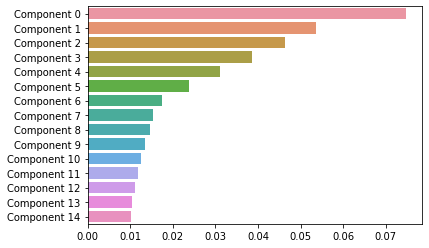

In [102]:
# plot of explained variance
comp_labels = [f'Component {x}' for x in range(len(exp_var))]
sns.barplot(x=exp_var[:15], y=comp_labels[:15])

In [103]:
# cumulative sum
cumsum_exp_var = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)  

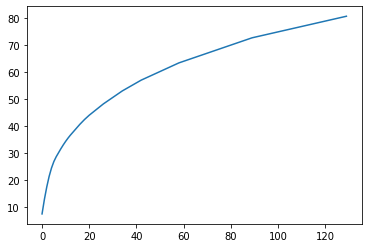

In [104]:
sns.lineplot(x=range(len(exp_var)), y=cumsum_exp_var)

In [105]:
cumsum_exp_var[129]

80.80000000000003

To reach an explained variance of ~80% I would have to include 130 principal components.

### Analysis of top principal components

Lets have a look at the top 3 most importance components and what kind of weighted linear combination of original features they consist of

In [106]:
# create dataframe for all the components
components_df = pd.DataFrame(pca.components_, columns=list(azdias.columns))
components_df.head()

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST,CJT_GESAMTTYP_2,CJT_GESAMTTYP_3,CJT_GESAMTTYP_4,CJT_GESAMTTYP_5,CJT_GESAMTTYP_6,KBA05_MAXSEG_2,KBA05_MAXSEG_3,KBA05_MAXSEG_4
0,0.116251,0.004911,0.006593,0.000780,-0.003852,-0.006340,0.007819,-0.000077,0.033212,-0.086015,...,-0.010105,-0.000820,-0.020870,0.014922,0.017193,0.003855,-0.011971,-0.035253,0.015610,0.001889
1,0.012023,0.079486,0.000853,-0.000108,0.010496,0.005091,0.000745,0.000015,0.000125,-0.045475,...,0.014335,0.000373,-0.064919,0.049445,0.066725,0.028727,-0.047639,-0.092267,0.037585,0.014339
2,-0.038753,-0.045331,0.002719,0.000809,-0.004174,-0.000947,0.003445,0.000355,0.009400,-0.071605,...,0.011610,0.001240,0.099599,-0.011200,-0.028220,-0.009002,-0.101720,-0.103898,0.039671,0.026850
3,-0.002539,0.004346,0.000577,0.000979,0.000632,0.000792,0.000575,0.000423,-0.011348,-0.107395,...,-0.002151,0.000512,-0.036055,0.014753,0.002552,-0.000029,0.034113,-0.056274,0.016934,0.077520
4,-0.171824,-0.004075,0.001437,0.000184,0.003706,0.008437,0.001773,0.000087,0.037523,-0.029852,...,0.019151,0.000834,-0.023494,-0.013656,-0.043866,0.005882,0.085775,0.107198,-0.043787,-0.032384


In [107]:
def pca_analysis(components_df, principal_component, no_weights=10):
    
    df = components_df.iloc[[principal_component]].sort_values(principal_component, axis=1, key=abs, ascending=False)
    
    # bar plot data
    weights = df.transpose().head(no_weights).transpose().values[0]
    labels = df.transpose().head(no_weights).transpose().columns
    
    sns.barplot(x=weights, y=labels)

    # First component with sorted top features
    return df.transpose().head(no_weights)

,0
KBA13_BAUMAX,0.162499
KBA13_ANTG4,0.161904
KBA05_ANTG1,-0.160534
PLZ8_ANTG4,0.159376
wealth,0.156569
PLZ8_BAUMAX,0.154245
KBA13_ANTG3,0.148031
MOBI_REGIO,-0.144109
PLZ8_ANTG3,0.143927
LP_FAMILIE_FEIN_1,0.141410


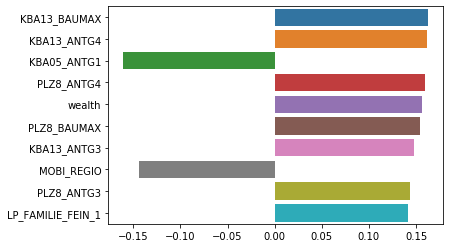

In [108]:
# first principal component
pca_analysis(components_df, principal_component=0)

,1
ZABEOTYP_3,-0.243493
D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,-0.230118
D19_KONSUMTYP_3,-0.191965
GEBURTSJAHR,0.186713
D19_GESAMT_ONLINE_QUOTE_12,0.176390
D19_KONSUMTYP_MAX,-0.176280
decade,0.171546
D19_VERSAND_ONLINE_QUOTE_12,0.164991
CJT_KATALOGNUTZER,-0.157498
CJT_TYP_4,-0.156478


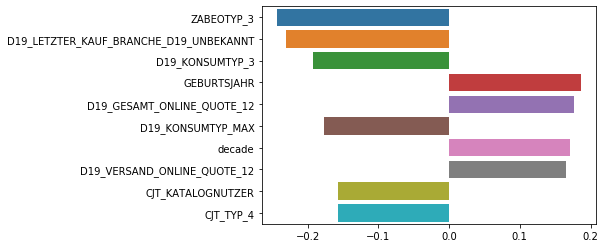

In [109]:
# second principal component
pca_analysis(components_df, principal_component=1)

,2
FINANZ_ANLEGER,-0.245476
FINANZ_UNAUFFAELLIGER,-0.236727
FINANZ_SPARER,-0.228646
CJT_TYP_2,-0.211455
CJT_TYP_1,-0.210844
FINANZ_VORSORGER,0.181552
SEMIO_REL,-0.179077
RT_KEIN_ANREIZ,-0.163269
FINANZTYP_4,-0.158518
SEMIO_PFLICHT,-0.145051


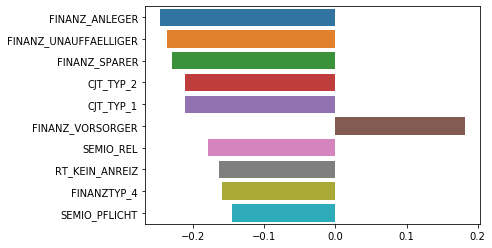

In [110]:
# third principal component
pca_analysis(components_df, principal_component=2)

### Clustering

Idea is to cluster the general population and then afterwards investigate if customers are under/over represented in som of the clusters. Over represented clusters are the part of the population that are more likely to become a customers as they share features with existing customers and vice versa.

In [111]:
# %%time
# # train a series of kmeans models
# results = []
# for n_clusters in range(2,26):
#     print('fitting to n_clusters:', n_clusters)
#     # define and fit to general population
#     kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(azdias_pca)
# #     score = kmeans.score(azdias_pca)  # SSE
#     score = kmeans.inertia_  # fast than calculating the score
#     results.append({'model':kmeans, 'n_clusters':n_clusters, 'score':abs(score)})

In [112]:
# # save the time consuming results
# with open("./data/kmeans_results.pkl","wb") as f:
#     pickle.dump(results, f)

In [113]:
# load the time consuming results
with open("./data/kmeans_results.pkl","rb") as f:
    results = pickle.load(f)

c:\users\kenne\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator KMeans from version 0.24.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


This was rather time-consuming and would properly had been sufficent to use MiniBatchKMeans.

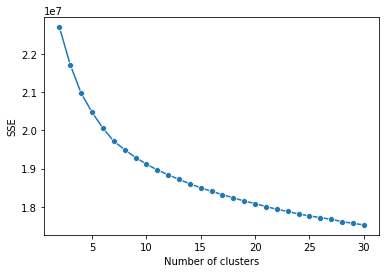

In [114]:
# elbow method plot
ax = sns.lineplot(x=[res['n_clusters'] for res in results],
                  y=[res['score'] for res in results],
                  marker='o')
ax.set(xlabel='Number of clusters', ylabel='SSE')
plt.show()

From this it's observed that the elbow is around 8 clusters.
The corresponding model are now used to predict labels or both datasets:

In [115]:
index = 6
kmeans = results[index]['model']
# print to confirm right index
print(results[index]['n_clusters'])

8


In [116]:
customers_pred = kmeans.predict(customers_pca)
azdias_pred = kmeans.predict(azdias_pca)

### Evaluate how the customers dataset distribute between the general population clusters

In [117]:
# Count how many samples fall inte each of the cluster from both the general population and the customers
azdias_cluster_counts = np.bincount(azdias_pred)
customers_cluster_counts = np.bincount(customers_pred)

In [118]:
# create dataframe for all the components
cluster_count_df = pd.DataFrame(columns=["Dataset", "Cluster", "Count"])
for dataset_name, dataset in {"customers":customers_cluster_counts, "azdias":azdias_cluster_counts}.items():
    for cluster, count in enumerate(dataset, 1):
        cluster_count_df = cluster_count_df.append({"Dataset" : dataset_name, "Cluster": cluster, "Count": count}, ignore_index=True)

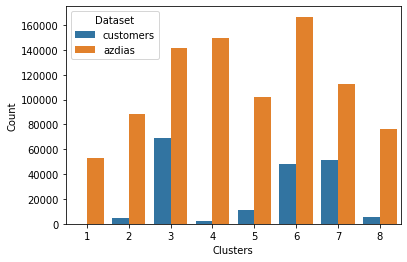

In [119]:
# plot
ax = sns.barplot(x='Cluster', y="Count", hue="Dataset", data=cluster_count_df)
ax.set(xlabel='Clusters', ylabel='Count')
plt.show()

From this it's can be seen that people in cluster 3 and 7 are the least attractive as almost none of the existing customers belong to these clusters.
On the other hand is cluster 1 and 5 observed to contain most of the existing customers and general population people in these cluster should be the most likely new customers.

Because of the many features in the dataset combined with the use of PCA it is impractical to reverse engineer which population features the sales organisation should target.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [120]:
# read data
mailout_train = pd.read_csv('./data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_test = pd.read_csv('./data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

c:\users\kenne\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Isolate Response column

In [121]:
# name of the response feature only present in train dataset
set(mailout_train.columns.values) - set(mailout_test.columns.values)

{'RESPONSE'}

In [122]:
response_target = mailout_train['RESPONSE']
mailout_train.drop('RESPONSE', axis=1, inplace=True)

In [123]:
# confirm the dimnesion aligned with what previously considered
print(mailout_train.shape)
print(mailout_test.shape)

(42962, 366)
(42833, 366)


### Cleaning
Now the data preprocessing is repeated on both of these dataset (except the part with dropping rows)

In [124]:
def clean(df):
    replace_unknowns_with_nans(df)
    correct_dtypes(df, dtype_columns)
    df['CAMEO_DEU_2015'].replace('XX', np.nan, inplace=True)
    df.drop(columns=features_to_drop, inplace=True)  # dropping columns with too many missing values
    df.drop(columns=['EINGEFUEGT_AM'], inplace=True)  # 'EINGEFUEGT_AM' with its datetime-like values are also dropped
    df.drop(columns=columns_to_drop, inplace=True)  # These columns are dropped because they got too many categories and cannot be aggregated nicely
    df['life_status'] = df['CAMEO_INTL_2015'].mod(10)  # extract ones / life_status
    df['wealth'] = (df['CAMEO_INTL_2015'] - df['life_status'])/10  # extract tens / wealth
    df.drop(columns=['CAMEO_INTL_2015'], inplace=True)
    df['style'] = df['PRAEGENDE_JUGENDJAHRE'].apply(myTransformer, mapper=style_map)  # construct 'style' feature
    df['decade'] = df['PRAEGENDE_JUGENDJAHRE'].apply(myTransformer, mapper=decade_map)  # construct 'decade' feature
    df.drop(columns=['PRAEGENDE_JUGENDJAHRE'], inplace=True)
    df.drop(columns=['LNR'], inplace=True)
    df = df.replace({pd.NA: np.nan})
    df = pd.DataFrame(imputer.transform(df), columns=df.columns, index=df.index).astype(df.dtypes.to_dict())
    replace_float64_with_int32(df)
    # df.to_csv('./data/?????_preprocessed.csv')
    for col, le in binary_encoders.items():
        df[col] = le.transform(df[col].values)
    df = pd.get_dummies(df, columns=true_multiclass, prefix=true_multiclass, drop_first=True)
    missing_features = set(azdias.columns) - set(df.columns)
    print('missing_features inserted:', missing_features)
    for col in missing_features:
        df[col] = 0
    df[numeric_columns] = scaler.transform(df[numeric_columns])
    return df

In [125]:
mailout_train = clean(mailout_train)
mailout_test = clean(mailout_test)

KeyErrors: 'BIP_FLAG'
KeyErrors: 'CAMEO_DEUINTL_2015'
KeyErrors: 'D19_BANKEN_DIREKT_RZ'
KeyErrors: 'D19_BANKEN_GROSS_RZ'
KeyErrors: 'D19_BANKEN_LOKAL_RZ'
KeyErrors: 'D19_BANKEN_REST_RZ'
KeyErrors: 'D19_BEKLEIDUNG_GEH_RZ'
KeyErrors: 'D19_BEKLEIDUNG_REST_RZ'
KeyErrors: 'D19_BILDUNG_RZ'
KeyErrors: 'D19_BIO_OEKO_RZ'
KeyErrors: 'D19_BUCH_RZ'
KeyErrors: 'D19_DIGIT_SERV_RZ'
KeyErrors: 'D19_DROGERIEARTIKEL_RZ'
KeyErrors: 'D19_ENERGIE_RZ'
KeyErrors: 'D19_FREIZEIT_RZ'
KeyErrors: 'D19_GARTEN_RZ'
KeyErrors: 'D19_HANDWERK_RZ'
KeyErrors: 'D19_HAUS_DEKO_RZ'
KeyErrors: 'D19_KINDERARTIKEL_RZ'
KeyErrors: 'D19_KK_KUNDENTYP'
KeyErrors: 'D19_KOSMETIK_RZ'
KeyErrors: 'D19_LEBENSMITTEL_RZ'
KeyErrors: 'D19_LOTTO_RZ'
KeyErrors: 'D19_NAHRUNGSERGAENZUNG_RZ'
KeyErrors: 'D19_RATGEBER_RZ'
KeyErrors: 'D19_REISEN_RZ'
KeyErrors: 'D19_SAMMELARTIKEL_RZ'
KeyErrors: 'D19_SCHUHE_RZ'
KeyErrors: 'D19_SONSTIGE_RZ'
KeyErrors: 'D19_TECHNIK_RZ'
KeyErrors: 'D19_TELKO_MOBILE_RZ'
KeyErrors: 'D19_TELKO_REST_RZ'
KeyErrors: 'D19_TIERAR

KeyErrors: 'SOHO_FLAG'
KeyErrors: 'WACHSTUMSGEBIET_NB'
KeyErrors: 'WACHSTUMSGEBIET_NB'
float64 AKT_DAT_KL
float64 ALTERSKATEGORIE_FEIN
float64 ANZ_HAUSHALTE_AKTIV
float64 ANZ_HH_TITEL
float64 ANZ_KINDER
float64 ANZ_PERSONEN
float64 ANZ_STATISTISCHE_HAUSHALTE
float64 ANZ_TITEL
float64 ARBEIT
float64 BALLRAUM
float64 CAMEO_DEUG_2015
float64 CJT_GESAMTTYP
float64 CJT_KATALOGNUTZER
float64 CJT_TYP_1
float64 CJT_TYP_2
float64 CJT_TYP_3
float64 CJT_TYP_4
float64 CJT_TYP_5
float64 CJT_TYP_6
float64 D19_BANKEN_ONLINE_QUOTE_12
float64 D19_GESAMT_ONLINE_QUOTE_12
float64 D19_KONSUMTYP
float64 D19_LOTTO
float64 D19_SOZIALES
float64 D19_TELKO_ONLINE_QUOTE_12
float64 D19_VERSAND_ONLINE_QUOTE_12
float64 D19_VERSI_ONLINE_QUOTE_12
float64 DSL_FLAG
float64 EINGEZOGENAM_HH_JAHR
float64 EWDICHTE
float64 FIRMENDICHTE
float64 GEBAEUDETYP
float64 GEBAEUDETYP_RASTER
float64 GEMEINDETYP
float64 GFK_URLAUBERTYP
float64 HEALTH_TYP
float64 HH_DELTA_FLAG
float64 HH_EINKOMMEN_SCORE
float64 INNENSTADT
float64 KBA05_

In [126]:
# shape inspection after dropping ppor columns
print(mailout_train.shape)
print(mailout_test.shape)
print(customers.shape)
print(azdias.shape)

(42962, 442)
(42833, 442)
(191649, 442)
(891203, 442)


### PCA and Clustering


In [127]:
# PCA
#mailout_train_pca = pca.transform(mailout_train)
#mailout_test_pca = pca.transform(mailout_test)

In [128]:
# Clustering
#mailout_train_pred = kmeans.predict(mailout_train_pca)
#mailout_test_pred = kmeans.predict(mailout_test_pca)

### Response data evaluated

In [129]:
# what does this response label look like
response_target.head()

0    0
1    0
2    0
3    0
4    0
Name: RESPONSE, dtype: int64

In [130]:
# count response types
response_target.value_counts().values/len(response_target)

array([0.98761696, 0.01238304])

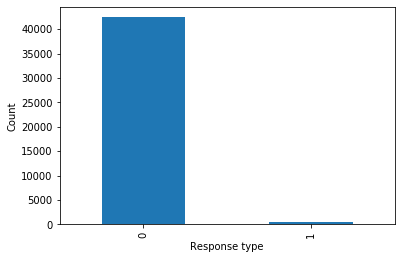

In [131]:
# plot of imballance
ax = response_target.value_counts().plot(kind='bar')
ax.set_xlabel("Response type")
ax.set_ylabel("Count")
plt.show()

Only 1.24% of the train dataset are positive samples. The 98.76% majority did not respond to the mailout campaign.
This means that we're dealing with a highlt imballanced dataset.

### Predictive modelling

In [132]:
# remap to X, y for convenience 
X = mailout_train
y = response_target

In [133]:
SEED = 51

#### SMOTE sampling

In [134]:
# oversample the minority class to a minority/majority-ratio of 0.1
oversampler = SMOTE(sampling_strategy=0.03, k_neighbors=50, n_jobs=-1, random_state=SEED)
# X, y = oversampler.fit_resample(X, y)

In [135]:
# check that the ratio was changed
# y.value_counts().values/len(y)

In [136]:
# undersampling majority class to a minority/majority-ratio of 0.5
undersampler = RandomUnderSampler(sampling_strategy=0.6, random_state=SEED)  
# X, y = undersampler.fit_resample(X, y)

In [137]:
# check that the ratio was changed
# y.value_counts().values/len(y)

#### Cross-validation with Stratified K-folds
I'll use stratified k-fold cross-validation to evaluate the model
k-folds cross validation to check the robustness of the solution.
The dataset is stratified, meaning that each fold of the cross-validation split will have the same class distribution as the original dataset

In [138]:
# Kfolds
# cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

### Benchmark model pipeline
I'm using the classic simple Logistic Regression model as a benchmark.

In [139]:
model = LogisticRegression(max_iter=1000)

In [140]:
# pipeline incl. resampling
pipeline = imbpipeline(steps = [['over', oversampler],
                                ['under', undersampler],
                                ['model', model],
                               ]
                      )

### Benchmark scores

In [141]:
#%%time
#scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)  # roc_auc / f1_macro
#print("%0.2f ROC-AUC with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

In [142]:
#%%time
#scores = cross_validate(pipeline, X, y, cv=cv, scoring=['roc_auc'], return_train_score=True, n_jobs=-1)
#print("%0.2f F1 with a standard deviation of %0.2f" % (scores['test_f1'].mean(), scores['test_f1'].std()))
#print("Train:  %0.2f ROC-AUC with a standard deviation of %0.2f" % (scores['train_roc_auc'].mean(), scores['train_roc_auc'].std()))
#print("Test:   %0.2f ROC-AUC with a standard deviation of %0.2f" % (scores['test_roc_auc'].mean(), scores['test_roc_auc'].std()))

### Rough grid-based hyper-parameter tuning for benchmark model
Even though the Logistic Regression model are kept at default parameters I'm still doing a bit of hyperparameter tuning on the sampling so the following model comparisons is more fair and isn't to governed by the sampling parameters.

In [143]:
# splitting the data into a train_val and a test part
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=SEED)

In [144]:
# defining gridsearch and parameter space
param_grid = {'over__sampling_strategy':[0.03, 0.04, 0.05],
              'over__k_neighbors':[20, 50, 100],
              'under__sampling_strategy':[0.6, 0.7, 0.8],
             }
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=cv,
                           refit=True,
                           verbose=10,
                           n_jobs=-1,
                          )

In [145]:
%%time
# executing grid search
grid_search.fit(X_train, y_train)
cv_score = grid_search.best_score_  # Score of best_estimator on the left out data.

# scoring best estimater
test_score = grid_search.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   41.6s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   48.5s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   55.4s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:  1.1min finished


Cross-validation score: 0.6359827032165917
Test score: 0.6833436710084904
Wall time: 1min 8s


In [146]:
# Parameter setting that gave the best estimater
grid_search.best_params_  

{'over__k_neighbors': 100,
 'over__sampling_strategy': 0.04,
 'under__sampling_strategy': 0.7}

In [147]:
# Manual scoring on hold-out test dataset
y_score = grid_search.predict_proba(X_test)[:, 1]
print(f"Test score:  {roc_auc_score(y_test, y_score, average='macro')}")

Test score:  0.6833436710084904


The best LR model ended up in the order of 0.65 ROC-AUC.
With a reasonable benchmark in place it's now time for the more advanced modelling.

### Model generic features

In [148]:
# pipeline incl. resampling
def pipeline_constructor(model):
    return imbpipeline(steps = [['over', oversampler],
                                ['under', undersampler],
                                ['model', model]])

In [149]:
def optimizer_constructor(model, search_spaces, n_iter=1):
    # sampling specific hyperparameters
    sampling_search_space = {'over__sampling_strategy': Real(0.013, 0.1, 'uniform'),
                             'over__k_neighbors': Integer(5, 100),
                             'under__sampling_strategy': Real(0.1, 1, 'uniform')}
    # extend model hyperparameter space with sampling parameters
    search_spaces.update(sampling_search_space)
    # fit parameters
    fit_params = {
            #'model__early_stopping_rounds': 30,
            #'model__eval_metric': 'multi_logloss',
            #'model__eval_set': [(X_test, y_test)],
            }
    return BayesSearchCV(estimator=pipeline_constructor(model), 
                                 search_spaces=search_spaces,
                                 fit_params=fit_params,
                                 scoring='roc_auc',  # metric from kaggle competition (not ideal for imbalanced data)
                                 cv=cv,
                                 refit=True,
                                 n_iter=n_iter,
                                 n_points=1,
                                 verbose=0,
                                 n_jobs=-1,
                                 random_state=SEED)

In [150]:
def myPrintStatus(x):
    '''callback printing during hyperparameter tuning'''
    # Get all the models tested so far in DataFrame format
    results = optimizer.cv_results_
    #estimater_name = bayes_search.estimator.__class__.__name__
    mean_test_score = results['mean_test_score'][-1]
    rank_test_score = results['rank_test_score'][-1]
    std_test_score = results['std_test_score'][-1]
    num_candidates = len(results['params'])
    best_score = optimizer.best_score_
    best_params = optimizer.best_params_
    print(f"Model candidate {num_candidates} (rank {rank_test_score}) - Current Cross-validation score: {mean_test_score:.2f} (best {best_score:.2f})")
    #pprint(f"Params: {results['params'][0]}\n")

In [151]:
def print_summary(optimizer):
    ''' print metrics '''
    estimater_name = optimizer.estimator.__class__.__name__
    if estimater_name == 'Pipeline':
        estimater_name = [step[1].__class__.__name__ for step in optimizer.estimator.steps if step[0] == 'model'][0]

    # extract optimizer parameters
    num_candidates = len(optimizer.cv_results_['params'])
    best_score = optimizer.best_score_
    best_params = optimizer.best_params_
    estimator = optimizer.best_estimator_
    
    print('----', estimater_name, '----')
    print('candidates checked:', num_candidates)
    print(f'best cross-validation score: {best_score:.3f}')   
    print('Best parameters:')
    pprint(best_params)
    print()

    def print_classification_report(y_truth, y_pred):
        print(classification_report(y_truth, y_pred))
        print('confussion matrix:')
        print(confusion_matrix(y_truth, y_pred))
        print()

    # make predictions with best estimator
    
    #y_train_pred = estimator.predict(X_train)   
        
    #print('---- Classification report for TRAIN dataset ----')
    #y_score = estimator.predict_proba(X_train)[:, 1]
    #print('ROC AUC score (macro):', round(roc_auc_score(y_train, y_score, average='macro'),3))
    #y_pred = estimator.predict(X_train)
    #print_classification_report(y_train, y_pred)
      
    #print('---- Classification report for TEST dataset ----')
    y_score = estimator.predict_proba(X_test)[:, 1]
    print('ROC AUC score (macro):', round(roc_auc_score(y_test, y_score, average='macro'),3))
    #y_pred = estimator.predict(X_test)
    #print_classification_report(y_test, y_pred)

      

### XGBoost model

In [152]:
model = xgb.XGBClassifier(n_jobs=-1,
                          objective='binary:logistic',
                          eval_metric='auc',  # metric from kaggle competition (not ideal for imbalanced data)
                          use_label_encoder=False,
                          tree_method='approx',
                          seed=SEED)

In [153]:
# XGBoost search spaces
ITERATIONS = 5
search_spaces = {'model__learning_rate': Real(0.01, 1.0, 'log-uniform'),
                 'model__min_child_weight': Integer(0, 10),
                 'model__max_depth': Integer(1, 50),
                 'model__max_delta_step': Integer(0, 20), # Maximum delta step we allow each leaf output
                 'model__subsample': Real(0.01, 1.0, 'uniform'),
                 'model__colsample_bytree': Real(0.01, 1.0, 'uniform'), # subsample ratio of columns by tree
                 'model__colsample_bylevel': Real(0.01, 1.0, 'uniform'), # subsample ratio by level in trees
                 'model__reg_lambda': Real(1e-9, 1000, 'log-uniform'), # L2 regularization
                 'model__reg_alpha': Real(1e-9, 1.0, 'log-uniform'), # L1 regularization
                 'model__gamma': Real(1e-9, 0.5, 'log-uniform'), # Minimum loss reduction for partition
                 'model__n_estimators': Integer(50, 100),
                 'model__scale_pos_weight': Real(1e-6, 500, 'log-uniform')}

In [154]:
%%time
optimizer = optimizer_constructor(model, search_spaces, n_iter=ITERATIONS)
result = optimizer.fit(#X, y, 
                       X_train, y_train, 
                       callback=[DeltaXStopper(0.001), 
                                 #DeadlineStopper(5*60), 
                                 myPrintStatus,
                                 ]
                          )

Model candidate 1 (rank 1) - Current Cross-validation score: 0.71 (best 0.71)
Model candidate 2 (rank 2) - Current Cross-validation score: 0.67 (best 0.71)
Model candidate 3 (rank 3) - Current Cross-validation score: 0.50 (best 0.71)
Model candidate 4 (rank 3) - Current Cross-validation score: 0.50 (best 0.71)
Model candidate 5 (rank 3) - Current Cross-validation score: 0.51 (best 0.71)
Wall time: 18.2 s


In [155]:
print_summary(optimizer)

---- XGBClassifier ----
candidates checked: 5
best cross-validation score: 0.713
Best parameters:
OrderedDict([('model__colsample_bylevel', 0.08916991901452663),
             ('model__colsample_bytree', 0.07133042624799589),
             ('model__gamma', 6.193069509877556e-08),
             ('model__learning_rate', 0.06663822043332003),
             ('model__max_delta_step', 1),
             ('model__max_depth', 4),
             ('model__min_child_weight', 0),
             ('model__n_estimators', 90),
             ('model__reg_alpha', 0.0045348167443284935),
             ('model__reg_lambda', 0.0002618901344145214),
             ('model__scale_pos_weight', 0.10972822258363321),
             ('model__subsample', 0.8961409541041984),
             ('over__k_neighbors', 92),
             ('over__sampling_strategy', 0.057508453775267886),
             ('under__sampling_strategy', 0.9618038317752836)])

ROC AUC score (macro): 0.705


c:\users\kenne\appdata\local\programs\python\python37\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


#### ---- XGBClassifier Experiment 1 ----
candidates checked: 300
best cross-validation score: 0.767
Hold-out test ROC AUC score (macro): 0.774
Best parameters:
OrderedDict([('model__colsample_bylevel', 0.37313018654120905),
             ('model__colsample_bytree', 1.0),
             ('model__gamma', 1.2993144371546726e-06),
             ('model__learning_rate', 0.01),
             ('model__max_delta_step', 11),
             ('model__max_depth', 39),
             ('model__min_child_weight', 10),
             ('model__n_estimators', 60),
             ('model__reg_alpha', 0.0001071944065801464),
             ('model__reg_lambda', 1.0511666183804571e-09),
             ('model__scale_pos_weight', 0.10482598118813549),
             ('model__subsample', 0.33170149730915915)])
            sampling_strategy=0.03, 
            k_neighbors=50


#### ---- XGBClassifier Experiment 2 ----
candidates checked: 300
best cross-validation score: 0.760
Hold-out test ROC AUC score (macro): 0.776
Best parameters:
OrderedDict([('model__colsample_bylevel', 0.5481240028615237),
             ('model__colsample_bytree', 0.8457029904352482),
             ('model__gamma', 4.982246302828535e-09),
             ('model__learning_rate', 0.08256497454249488),
             ('model__max_delta_step', 13),
             ('model__max_depth', 50),
             ('model__min_child_weight', 3),
             ('model__n_estimators', 86),
             ('model__reg_alpha', 0.7449176892953915),
             ('model__reg_lambda', 310.05233497899724),
             ('model__scale_pos_weight', 1.4494184754970976),
             ('model__subsample', 0.8552179878805323)])



#### ---- XGBClassifier Experiment 3 ----
candidates checked: 100
best cross-validation score: 0.764
(Train ROC AUC score (macro): 0.82)
Best parameters:
OrderedDict([('model__colsample_bylevel', 0.8909763934875194),
             ('model__colsample_bytree', 0.8459260010050229),
             ('model__gamma', 6.594479179399154e-06),
             ('model__learning_rate', 0.10491373218920595),
             ('model__max_delta_step', 4),
             ('model__max_depth', 3),
             ('model__min_child_weight', 0),
             ('model__n_estimators', 61),
             ('model__reg_alpha', 9.286935228610291e-06),
             ('model__reg_lambda', 85.32842279815551),
             ('model__scale_pos_weight', 7.301821065094156),
             ('model__subsample', 0.5101084763350213),
             ('over__k_neighbors', 28),
             ('over__sampling_strategy', 0.013),
             ('under__sampling_strategy', 0.5426795915787295)])


#### ---- XGBClassifier Experiment 4 ----
candidates checked: 100
best cross-validation score: 0.772
(Train ROC AUC score (macro): 0.839)
Best parameters:
OrderedDict([('model__colsample_bylevel', 0.6084585284681691),
             ('model__colsample_bytree', 0.5964554313403541),
             ('model__gamma', 2.4813274234538006e-05),
             ('model__learning_rate', 0.01),
             ('model__max_delta_step', 0),
             ('model__max_depth', 7),
             ('model__min_child_weight', 10),
             ('model__n_estimators', 100),
             ('model__reg_alpha', 1e-09),
             ('model__reg_lambda', 7.197995645583151e-06),
             ('model__scale_pos_weight', 0.7353101983966908),
             ('model__subsample', 0.9629613341073688),
             ('over__k_neighbors', 5),
             ('over__sampling_strategy', 0.013),
             ('under__sampling_strategy', 0.6416648367206704)])

In [156]:
# Manual scoring on hold-out test dataset
y_score = optimizer.predict_proba(X_test)[:, 1]
print(f"Test score:  {roc_auc_score(y_test, y_score, average='macro')}")

Test score:  0.7050722414525213


c:\users\kenne\appdata\local\programs\python\python37\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [157]:
# optimal hyperparameters found (from experiment 4)
tuned_params = {'model__colsample_bylevel': 0.6084585284681691,
                'model__colsample_bytree': 0.5964554313403541,
                'model__gamma': 2.4813274234538006e-05,
                'model__learning_rate': 0.01,
                'model__max_delta_step': 0,
                'model__max_depth': 7,
                'model__min_child_weight': 10,
                'model__n_estimators': 100,
                'model__reg_alpha': 1e-09,
                'model__reg_lambda': 7.197995645583151e-06,
                'model__scale_pos_weight': 0.7353101983966908,
                'model__subsample': 0.9629613341073688,
                'over__k_neighbors': 5,
                'over__sampling_strategy': 0.013,
                'under__sampling_strategy': 0.6416648367206704,
                }

In [158]:
# set hyperparameters
estimator = optimizer.best_estimator_
estimator.set_params(**tuned_params)    

Pipeline(steps=[('over',
                 SMOTE(n_jobs=-1, random_state=51, sampling_strategy=0.013)),
                ('under',
                 RandomUnderSampler(random_state=51,
                                    sampling_strategy=0.6416648367206704)),
                ['model',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=0.6084585284681691,
                               colsample_bynode=1,
                               colsample_bytree=0.5964554313403541,
                               eval_metric='auc', gamma=2.481327423453...
                               max_delta_step=0, max_depth=7,
                               min_child_weight=10, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=-1, num_parallel_tree=1, random_state=51,
                               reg_alpha=1e-09,
                               reg_lambda=7.19799564558315

In [159]:
%%time
# retrain tuned model on full dataset not with-holding anything for testing
scores = cross_val_score(estimator, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print("%0.2f ROC-AUC with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.77 ROC-AUC with a standard deviation of 0.03
Wall time: 2.3 s


In [160]:
# feature_importances
feature_importances = estimator.steps[-1][-1].feature_importances_
pd.Series(feature_importances, index=X.columns).sort_values(ascending=False).head(10)

HEALTH_TYP               0.028622
KBA05_MAXAH              0.025687
D19_KOSMETIK             0.025257
KBA05_MODTEMP            0.021047
KBA13_KMH_0_140          0.020183
CAMEO_DEUG_2015_2        0.019715
CJT_GESAMTTYP_6          0.019370
FINANZ_UNAUFFAELLIGER    0.018951
FINANZ_SPARER            0.018323
VK_ZG11                  0.016665
dtype: float32

### LightGBM

In [161]:
model = lgb.LGBMClassifier(boosting_type='gbdt',
                           class_weight='balanced',
                           objective='binary',
                           metric='auc',  # metric from kaggle competition (not ideal for imbalanced data)
                           n_jobs=-1, 
                           verbose=0)

In [162]:
# LightGBM search spaces
ITERATIONS = 5
search_spaces = {
        'model__learning_rate': Real(0.01, 1.0, 'log-uniform'),  #  default=0.1 – Boosting learning rate
        'model__num_leaves': Integer(2, 500),  # default=31 - Maximum tree leaves for base learners
        'model__max_depth': Integer(0, 500),  # default=-1 – Maximum tree depth for base learners (<=0 means no limit)
        'model__min_child_samples': Integer(0, 200), # minimal number of data in one leaf
        'model__max_bin': Integer(100, 100000), # max number of bins that feature values will be bucketed
        'model__subsample': Real(0.01, 1.0, 'uniform'),
        'model__subsample_freq': Integer(0, 10), # bagging fraction
        'model__colsample_bytree': Real(0.01, 1.0, 'uniform'), # enabler of bagging fraction
        'model__min_child_weight': Integer(0, 10), # minimal number of data in one leaf.
        'model__subsample_for_bin': Integer(100000, 500000), # number of data that sampled for histogram bins
        'model__reg_lambda': Real(1e-9, 1000, 'log-uniform'), # L2 regularization
        'model__reg_alpha': Real(1e-9, 1.0, 'log-uniform'), # L1 regularization
        'model__scale_pos_weight': Real(1e-6, 500, 'log-uniform'), 
        'model__n_estimators': Integer(10, 10000)        
        }

In [163]:
%%time
optimizer = optimizer_constructor(model, search_spaces, n_iter=ITERATIONS)
result = optimizer.fit(X, y, 
                           #X_train, y_train, 
                           callback=[DeltaXStopper(0.001), 
                                     #DeadlineStopper(5*60), 
                                     myPrintStatus,
                                     ]
                          )

Model candidate 1 (rank 1) - Current Cross-validation score: 0.69 (best 0.69)
Model candidate 2 (rank 2) - Current Cross-validation score: 0.64 (best 0.69)
Model candidate 3 (rank 3) - Current Cross-validation score: 0.50 (best 0.69)
Model candidate 4 (rank 3) - Current Cross-validation score: 0.50 (best 0.69)
Model candidate 5 (rank 3) - Current Cross-validation score: 0.50 (best 0.69)
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [164]:
print_summary(optimizer)

---- LGBMClassifier ----
candidates checked: 5
best cross-validation score: 0.686
Best parameters:
OrderedDict([('model__colsample_bytree', 0.08916991901452663),
             ('model__learning_rate', 0.013301476484585932),
             ('model__max_bin', 20678),
             ('model__max_depth', 206),
             ('model__min_child_samples', 12),
             ('model__min_child_weight', 1),
             ('model__n_estimators', 171),
             ('model__num_leaves', 401),
             ('model__reg_alpha', 0.0045348167443284935),
             ('model__reg_lambda', 0.0002618901344145214),
             ('model__scale_pos_weight', 0.10972822258363321),
             ('model__subsample', 0.8961409541041984),
             ('model__subsample_for_bin', 465550),
             ('model__subsample_freq', 5),
             ('over__k_neighbors', 96),
             ('over__sampling_strategy', 0.060260759465289984),
             ('under__sampling_strategy', 0.8718441040544251)])

ROC AUC score (macro): 

#### ---- LGBMClassifier Experiment 1 ----
candidates checked: 100
best cross-validation score: 0.767
Best parameters:
OrderedDict([('model__colsample_bytree', 0.8284516524596438),
             ('model__learning_rate', 0.015083510496268243),
             ('model__max_bin', 43619),
             ('model__max_depth', 127),
             ('model__min_child_samples', 104),
             ('model__min_child_weight', 5),
             ('model__n_estimators', 5692),
             ('model__num_leaves', 500),
             ('model__reg_alpha', 1e-09),
             ('model__reg_lambda', 1.3882844300257421e-06),
             ('model__scale_pos_weight', 0.0019705526075344073),
             ('model__subsample', 0.5831956543963555),
             ('model__subsample_for_bin', 447987),
             ('model__subsample_freq', 2),
             ('over__k_neighbors', 57),
             ('over__sampling_strategy', 0.016204352877126526),
             ('under__sampling_strategy', 0.1)])

The LGBM classifier easily did better than the benchmark but was with a cross-validation score of 0.767 not able to beat the XGBoost model above.

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [165]:
# reload the test dataset to extract the LNR index needed for the submission
mailout_test_org = pd.read_csv('./data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

c:\users\kenne\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [166]:
# prediction on test set
y_score = estimator.predict_proba(mailout_test)
kaggle_submission = pd.DataFrame({'LNR':mailout_test_org.LNR, 
                                'RESPONSE':y_score[:,1]})

kaggle_submission.head()

c:\users\kenne\appdata\local\programs\python\python37\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


,LNR,RESPONSE
0,1754,0.070541
1,1770,0.046079
2,1465,0.027274
3,1470,0.027852
4,1478,0.041287


In [167]:
kaggle_submission.to_csv('submission.csv', index=False)